## Evaluation Metrics

### 4.1: Overview

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv("../../03-classification/data/telco-customer-churn.csv")

# keep data format in consistent format
df.columns = df.columns.str.lower().str.replace(" ", "_")

cat_cols = df.dtypes[df.dtypes == "object"].index

for c in cat_cols:
    df[c] = df[c].str.lower().str.replace(" ", "_")

# fill nulls for the numeric data 
df.totalcharges = pd.to_numeric(df.totalcharges, errors="coerce")
df.totalcharges = df.totalcharges.fillna(0)

# convert type of target y
df.churn = (df.churn == "yes").astype(int)

In [4]:
# validation framework
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train.reset_index(drop=True)
df_val.reset_index(drop=True)
df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train["churn"]
del df_val["churn"]
del df_test["churn"]

In [5]:
# numerical features vs. categorical features
num_vars = ["tenure", "monthlycharges", "totalcharges"]

cat_vars = ['gender', 'partner', 'dependents', 'phoneservice',
            'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup',
            'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies',
            'contract', 'paperlessbilling', 'paymentmethod']

In [6]:
# get X_train and train the model
dv = DictVectorizer(sparse=False)

dict_train = df_train[num_vars + cat_vars].to_dict(orient="records")
X_train = dv.fit_transform(dict_train)

model = LogisticRegression(max_iter=3000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,3000
,multi_class,'deprecated'


In [7]:
# get predictions from X_val
dict_val = df_val[num_vars + cat_vars].to_dict(orient="records")
X_val = dv.transform(dict_val)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.7977288857345636)

### 4.2: Accuracy & Dummy Model

In [8]:
from sklearn.metrics import accuracy_score

accuracy_score(y_val, y_pred >= 0.5)

0.7977288857345636

In [9]:
thresholds = np.linspace(0, 1, 21)
scores = []

for t in thresholds:
    score = accuracy_score(y_val, (y_pred >= t))
    print(f"{t:.3f} >> {score}")
    scores.append(score)

0.000 >> 0.2739531582682754
0.050 >> 0.5117104329311568
0.100 >> 0.6068133427963094
0.150 >> 0.6628814762242725
0.200 >> 0.7075940383250532
0.250 >> 0.7331440738112136
0.300 >> 0.758694109297374
0.350 >> 0.7650816181689141
0.400 >> 0.7821149751596878
0.450 >> 0.7863733144073811
0.500 >> 0.7977288857345636
0.550 >> 0.8062455642299503
0.600 >> 0.7984386089425124
0.650 >> 0.7885024840312278
0.700 >> 0.7665010645848119
0.750 >> 0.7402413058907026
0.800 >> 0.7281760113555713
0.850 >> 0.7260468417317246
0.900 >> 0.7260468417317246
0.950 >> 0.7260468417317246
1.000 >> 0.7260468417317246


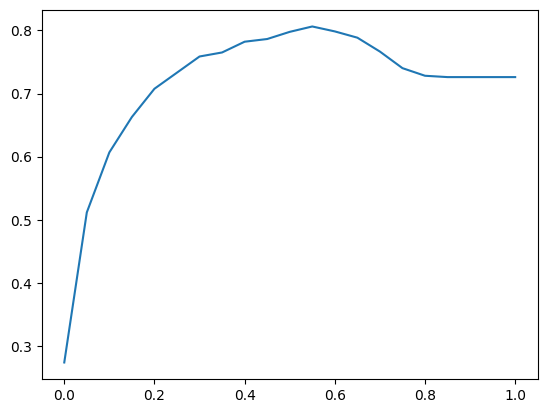

In [10]:
plt.plot(thresholds, scores)

In [11]:
from collections import Counter

Counter(y_pred > 1.0)

Counter({np.False_: 1409})

In [12]:
1 - y_val.mean()

np.float64(0.7260468417317246)

### 4.3: Confusion Table

In [13]:
actual_negative = (y_val == 0)
actual_positive = (y_val == 1)

In [14]:
t = 0.5
predict_negative = (y_pred < t)
predict_positive = (y_pred >= t)

In [15]:
tn = (actual_negative & predict_negative).sum()
tp = (actual_positive & predict_positive).sum()

fn = (actual_positive & predict_negative).sum()
fp = (actual_negative & predict_positive).sum()

In [16]:
confusion_matrix = np.array([[tn, fp], [fn, tp]])
confusion_matrix

array([[914, 109],
       [176, 210]])

In [17]:
(confusion_matrix / confusion_matrix.sum()).round(3)

array([[0.649, 0.077],
       [0.125, 0.149]])

### 4.4: Precision & Recall

In [18]:
p = tp / (tp + fp)
p

np.float64(0.658307210031348)

In [19]:
r = tp / (tp + fn)
r

np.float64(0.5440414507772021)

### 4.5: ROC Curves

**TPR & FPR**

In [20]:
# tp / actual_positives
tpr = tp / (tp + fn)
tpr

np.float64(0.5440414507772021)

In [21]:
# fp / actual_negatives
fpr = fp / (fp + tn)
fpr

np.float64(0.10654936461388075)

In [22]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_neg = (y_val == 0)
    actual_pos = (y_val == 1)

    predict_neg = (y_pred < t)
    predict_pos = (y_pred >= t)

    tn = (actual_neg & predict_neg).sum()
    fp = (actual_neg & predict_pos).sum()

    fn = (actual_pos & predict_neg).sum()
    tp = (actual_pos & predict_pos).sum()

    scores.append((t, tn, fn, tp, fp))

In [23]:
columns = ["threshold", "tn", "fn", "tp", "fp"]
df_scores = pd.DataFrame(scores, columns=columns)

df_scores["tpr"] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores["fpr"] = df_scores.fp / (df_scores.fp + df_scores.tn)

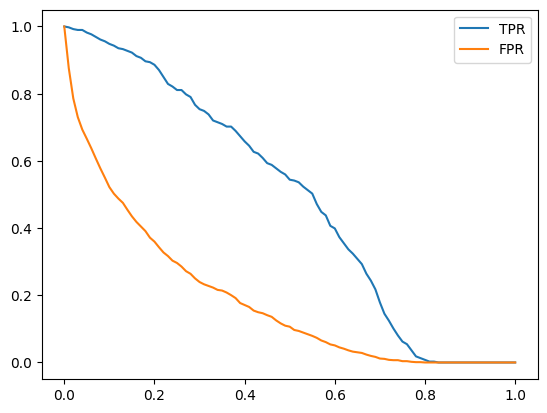

In [24]:
plt.plot(df_scores.threshold, df_scores.tpr, label="TPR")
plt.plot(df_scores.threshold, df_scores.fpr, label="FPR")
plt.legend()

**Random Model**

In [25]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [26]:
((y_rand >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)

In [27]:
def tpr_fpr_df(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_pos = (y_val == 1)
        actual_neg = (y_val == 0)

        predict_pos = (y_pred >= t)
        predict_neg = (y_pred < t)

        tp = (predict_pos & actual_pos).mean()
        tn = (predict_neg & actual_neg).mean()

        fp = (predict_pos & actual_neg).mean()
        fn = (predict_neg & actual_pos).mean()

        scores.append((t, tp, fp, tn, fn))

    columns = ["threshold", "tp", "fp", "tn", "fn"]
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores["tpr"] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores["fpr"] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

In [28]:
df_rand = tpr_fpr_df(y_val, y_rand)

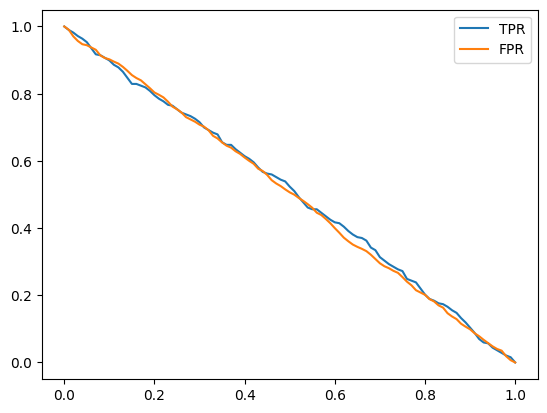

In [29]:
plt.plot(df_rand.threshold, df_rand.tpr, label="TPR")
plt.plot(df_rand.threshold, df_rand.fpr, label="FPR")
plt.legend()

**Ideal Model**

In [30]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(np.int64(1023), np.int64(386))

In [31]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal_pred = np.linspace(0, 1, len(y_val))
y_ideal_pred

array([0.00000000e+00, 7.10227273e-04, 1.42045455e-03, ...,
       9.98579545e-01, 9.99289773e-01, 1.00000000e+00], shape=(1409,))

In [32]:
1 - y_val.mean()

np.float64(0.7260468417317246)

In [33]:
accuracy_score(y_ideal, y_ideal_pred >= 0.726)

1.0

In [34]:
df_ideal = tpr_fpr_df(y_ideal, y_ideal_pred)

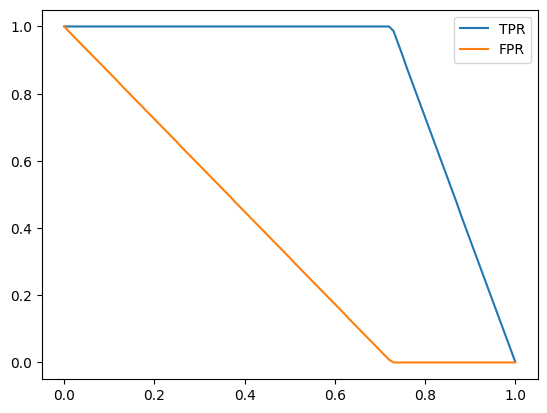

In [35]:
plt.plot(df_ideal.threshold, df_ideal.tpr, label="TPR")
plt.plot(df_ideal.threshold, df_ideal.fpr, label="FPR")
plt.legend()

**All Together**

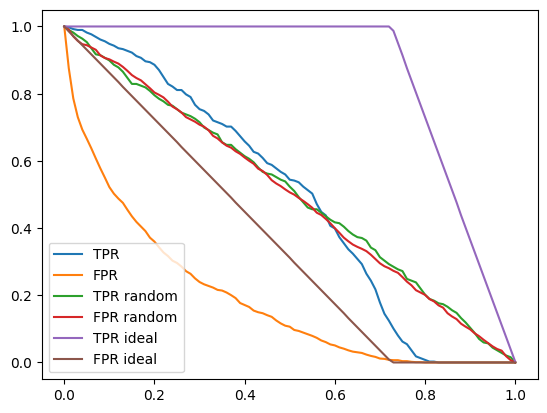

In [36]:
plt.plot(df_scores.threshold, df_scores.tpr, label="TPR")
plt.plot(df_scores.threshold, df_scores.fpr, label="FPR")

plt.plot(df_rand.threshold, df_rand.tpr, label="TPR random")
plt.plot(df_rand.threshold, df_rand.fpr, label="FPR random")

plt.plot(df_ideal.threshold, df_ideal.tpr, label="TPR ideal")
plt.plot(df_ideal.threshold, df_ideal.fpr, label="FPR ideal")

plt.legend()

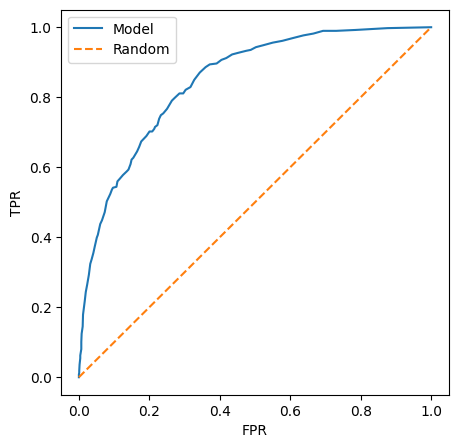

In [37]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label="Model")
plt.plot([0, 1], [0, 1], label="Random", linestyle="--")

plt.xlabel("FPR")
plt.ylabel("TPR")

plt.legend()

In [38]:
from sklearn.metrics import roc_curve

In [39]:
fpr, tpr, threshold = roc_curve(y_val, y_pred)

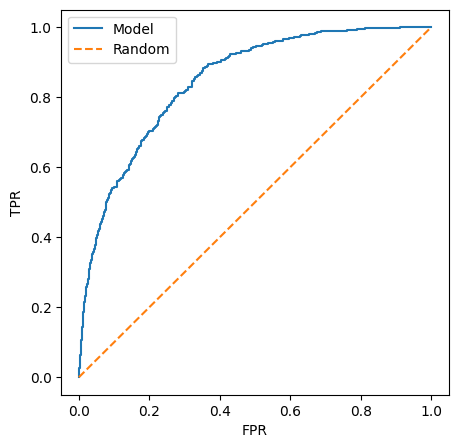

In [40]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label="Model")
plt.plot([0, 1], [0, 1], label="Random", linestyle="--")

plt.xlabel("FPR")
plt.ylabel("TPR")

plt.legend()

### 4.6: ROC AUC

In [41]:
from sklearn.metrics import auc

In [42]:
auc(fpr, tpr)

0.8464589062951088

In [43]:
auc(df_scores.fpr, df_scores.tpr)

0.8461866703133625

In [44]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [46]:
from sklearn.metrics import roc_auc_score

In [47]:
roc_auc_score(y_val, y_pred)

0.8464589062951088

Random examples selection

In [48]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [49]:
import random

In [51]:
n = 10000000
success = 0

for i in range(n):
    pos_idx = random.randint(0, len(pos) - 1)
    neg_idx = random.randint(0, len(neg) - 1)

    if pos[pos_idx] > neg[neg_idx]:
        success += 1

success / n

0.846419

In [53]:
n = 500000

np.random.seed(1)
pos_idx = np.random.randint(0, len(pos), size=n)
neg_idx = np.random.randint(0, len(neg), size=n)

(pos[pos_idx] > neg[neg_idx]).mean()

np.float64(0.84629)

### 4.7: Cross Validation

In [75]:
def train_model(df_train, y_train, C=1.0):
    dict_train = df_train[num_vars + cat_vars].to_dict(orient="records")

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dict_train)

    model = LogisticRegression(C=C, max_iter=5000)
    model.fit(X_train, y_train)

    return dv, model

In [76]:
dv, model = train_model(df_train, y_train, C=0.001)

In [77]:
def predict(df, dv, model):
    dict_ = df[num_vars + cat_vars].to_dict(orient="records")

    X = dv.transform(dict_)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [78]:
y_pred = predict(df_val, dv, model)

In [79]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [80]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kf.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train_model(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print(f"{C} >> {np.mean(scores)} +- {np.std(scores)}")

  0%|          | 0/7 [00:00<?, ?it/s]

0.001 >> 0.8246889300605329 +- 0.009323452072222484
0.01 >> 0.8395853012575462 +- 0.008342735532993903
0.1 >> 0.841609795337965 +- 0.007397535134604415
0.5 >> 0.841747009547962 +- 0.007090111305205923
1 >> 0.841637438599259 +- 0.007028164543429359
5 >> 0.8415737720567975 +- 0.006929522408490703
10 >> 0.8415458027786595 +- 0.006896840471563764


In [81]:
dv, model = train_model(df_full_train, df_full_train.churn.values, C=0.5)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8577559123360092